# Лабортарная работа №1

### Салятов Сергей, Подосенов Андрей, M3337

##### Задание 1

Возьмём Гамма-распределение:

$$
f(x) = \begin{cases}
x^{k-1}\frac{e^{-\frac{x}{\theta}}}{\Gamma(k) \theta^k}, & x \geq 0 \\
0, & x < 0
\end{cases}
$$

 с параметрами $\theta = 2, k = 3$:

$$
f(x) = \begin{cases}
x^2\frac{e^{-\frac{x}{2}}}{\Gamma(3) 2^3}, & x \geq 0 \\
0, & x < 0
\end{cases}
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

#### Вводим начальные значания, расчитываем теоретические формулы

In [2]:
SAMPLE_SIZE = 10000
SAMPLE_COUNT = 10000

k = 3
theta = 2

distribution = stats.gamma(a=k, scale=theta)

print(f"Количество выборок: {SAMPLE_COUNT}")
print(f"Объем каждой выборки: {SAMPLE_SIZE}")

THEORETICAL_MEAN = k * theta
THEORETICAL_VARIANCE = k * theta ** 2

theoretical_params = {
    'mean': THEORETICAL_MEAN, # k*theta 
    'variance': THEORETICAL_VARIANCE, # k * thetha**2
}


print("=== Теоретические параметры ===")
for key, value in theoretical_params.items():
    print(f"{key}: {value:.4f}")

Количество выборок: 10000
Объем каждой выборки: 10000
=== Теоретические параметры ===
mean: 6.0000
variance: 12.0000


#### Подготавливаем массивы

In [3]:
means = np.zeros(SAMPLE_COUNT)
variances = np.zeros(SAMPLE_COUNT)
medians = np.zeros(SAMPLE_COUNT)
nF_X2 = np.zeros(SAMPLE_COUNT)
n1F_Xn2 = np.zeros(SAMPLE_COUNT)

#### Функции для вычисления выборочных статистик

In [4]:
def mean(sample: list[float]) -> float:
    return sum(sample) / len(sample)

def var(sample: list[float], mean: float) -> float:
    return sum((element - mean) ** 2 for element in sample) / len(sample)

def median(sorted_sample: list[float]) -> float:
    if len(sorted_sample) % 2 == 1:
        return sorted_sample[len(sorted_sample) // 2]
    return (sorted_sample[len(sorted_sample) // 2 - 1] + sorted_sample[len(sorted_sample) // 2]) / 2

#### Вычисляем выборочные статистики

In [5]:
for i in range(SAMPLE_COUNT):
    sample = distribution.rvs(size=SAMPLE_SIZE)
    
    means[i] = mean(sample)
    variances[i] = var(sample, means[i])
   
    sorted_sample = sorted(sample)
    
    medians[i] = median(sorted_sample)
    
    nF_X2[i] = SAMPLE_SIZE * distribution.cdf(sorted_sample[1])
    
    n1F_Xn2[i] = SAMPLE_SIZE * (1 - distribution.cdf(sorted_sample[-3]))

print("\n=== Описательные статистики ===")
statistics = {
    'Выборочное среднее': means,
    'Выборочная дисперсия': variances, 
    'Медиана': medians,
    'nF(X_2)': nF_X2,
    'n(1-F(X_(n-2)))': n1F_Xn2
}

for name, data in statistics.items():
    print(f"{name}:")
    print(f"  Среднее = {np.mean(data):.4f}, Дисперсия = {np.var(data):.4f}")
    print(f"  Std = {np.std(data):.4f}, Медиана = {np.median(data):.4f}")


=== Описательные статистики ===
Выборочное среднее:
  Среднее = 6.0000, Дисперсия = 0.0012
  Std = 0.0348, Медиана = 6.0004
Выборочная дисперсия:
  Среднее = 11.9977, Дисперсия = 0.0577
  Std = 0.2402, Медиана = 11.9934
Медиана:
  Среднее = 5.3483, Дисперсия = 0.0017
  Std = 0.0409, Медиана = 5.3486
nF(X_2):
  Среднее = 1.9835, Дисперсия = 1.9407
  Std = 1.3931, Медиана = 1.6758
n(1-F(X_(n-2))):
  Среднее = 3.0062, Дисперсия = 3.0163
  Std = 1.7367, Медиана = 2.6874


#### Аналитические формулы для асимптотической нормальности

##### Математическое ожидание

По ЦПТ имеем: 

$$
\sqrt{n} ( \bar{X}_n - \mu ) \stackrel{d}{\longrightarrow} N(0, \sigma^2)
$$

Далее несложными преобразованиями (линейность математического ожидания, вынос константы в квадрате для дисперсии и независимость дисперсии от константы) получаем:

$$
\bar{X}_n \stackrel{a}{\sim} N \left( \mu, \frac{\sigma^2}{n} \right)
$$

Так как второй аргумент в *scipy* - стандартное нормальное отклонение, а не дисперсия, то берём корень (нужна $\sigma$, а не $\sigma^2$)

In [6]:
NORM_MEAN = (THEORETICAL_MEAN, (THEORETICAL_VARIANCE / SAMPLE_SIZE) ** 0.5)

##### Дисперсия

По ЦПТ и дельта-методу для дисперсии имеем: 

$$
\sqrt{n} ( S^2_n - \sigma^2 ) \stackrel{d}{\longrightarrow} N(0, \mu_4 - \sigma^4)
$$, где $\mu_4$ - 4-ый центральный момент распределения.

Преобразовываем:

$$
S^2_n \stackrel{a}{\sim} N \left( \sigma^2, \frac{\mu_4 - \sigma^4}{n} \right)
$$

Считаем 4-ый центральный момент через обычные (нецентральные). Просто раскрываем скобки и используем библиотечную реализацию моментов

In [7]:
m1 = distribution.moment(1)
m2 = distribution.moment(2)
m3 = distribution.moment(3)
m4 = distribution.moment(4)
mu_4 = m4 - 4 * m1 * m3 + 6 * m1**2 * m2 - 4 * m1**3 * m1 + m1**4
asymptotic_variance_variance = (mu_4 - THEORETICAL_VARIANCE**2) / SAMPLE_SIZE
NORM_VARIANCE = (THEORETICAL_VARIANCE, asymptotic_variance_variance ** 0.5)

##### Медиана

Раскладываем вокруг истинной медианы и по ЦПТ для биномиального распределения имеем: 

$$
\sqrt{n} ( m_n - m ) \stackrel{d}{\longrightarrow} N \left(0, \frac{1}{4 f(m)^2} \right)
$$

Опять преобразовываем:

$$
m_n \stackrel{a}{\sim} N \left( m, \frac{1}{4 n f(m)^2} \right)
$$

In [8]:
m = distribution.median()
f_m = distribution.pdf(m)
NORM_MEDIAN = (m, (1 / (2 * SAMPLE_SIZE**0.5 * f_m)))

#### Рисуем графики


📊 ТЕОРЕТИЧЕСКИЕ ПАРАМЕТРЫ ГАММА-РАСПРЕДЕЛЕНИЙ:
Параметр        Γ(2,1)       Γ(3,1)      
---------------------------------------------
Среднее         2.0000       3.0000      
Дисперсия       2.0000       3.0000      
Std             1.4142       1.7321      
Медиана         1.6783       2.6741      


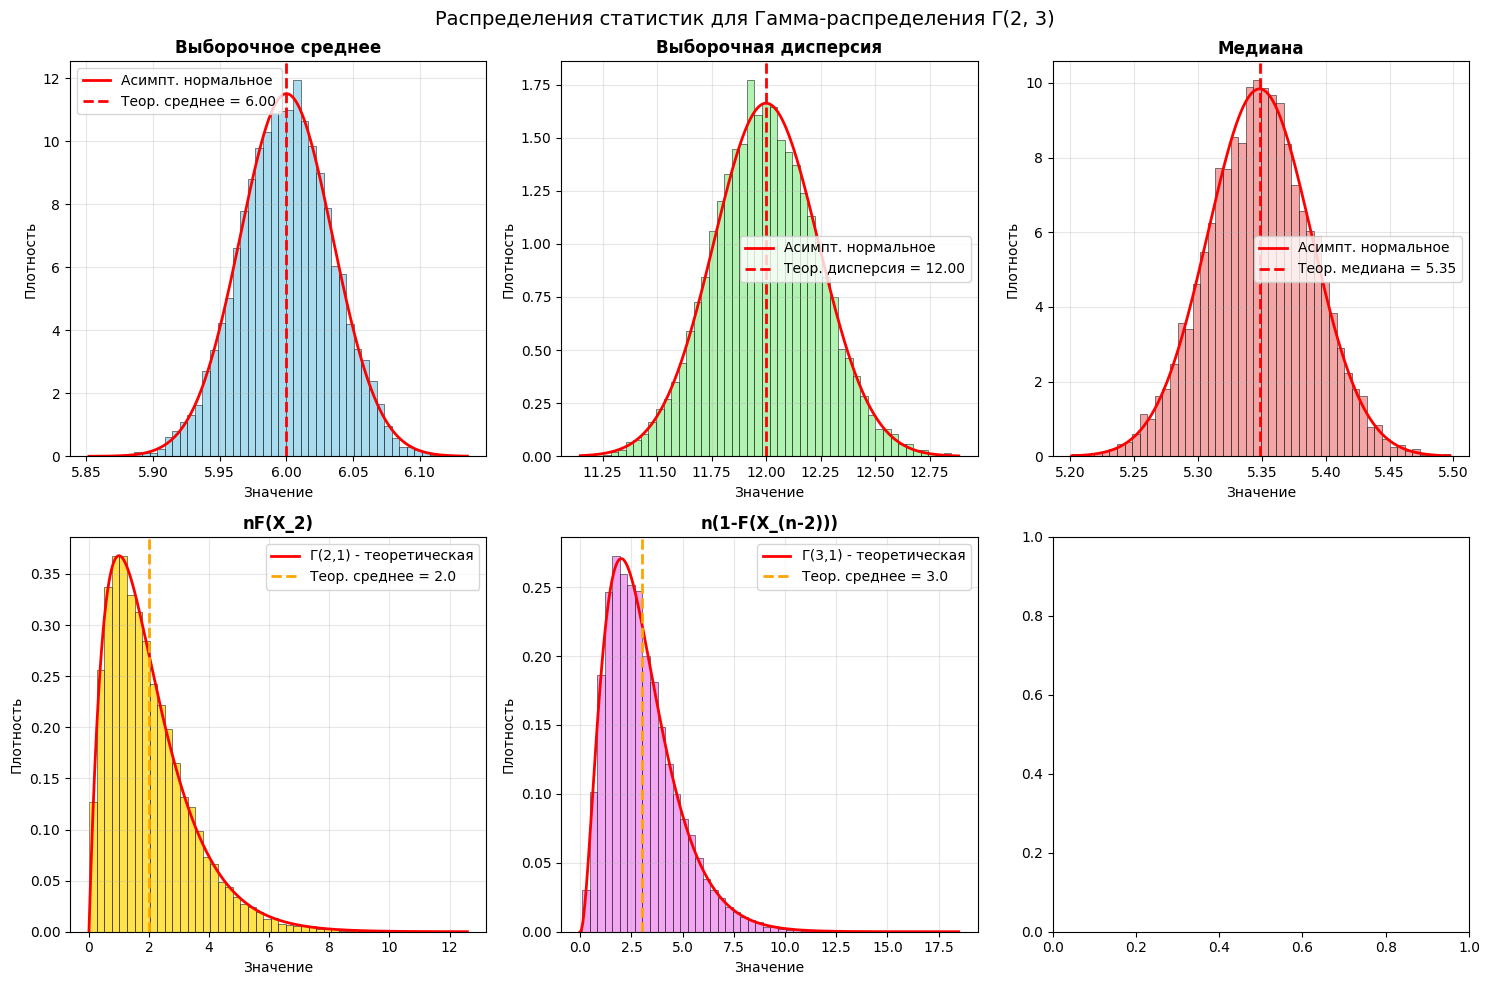

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Распределения статистик для Гамма-распределения Γ(2, 3)', fontsize=14)

titles = ['Выборочное среднее', 'Выборочная дисперсия', 'Медиана', 'nF(X_2)', 'n(1-F(X_(n-2)))']
datas = [means, variances, medians, nF_X2, n1F_Xn2]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'violet']

for i, (ax, data, title, color) in enumerate(zip(axes.flatten()[:5], datas, titles, colors)):
    ax.hist(data, bins=50, density=True, alpha=0.7, color=color, 
           edgecolor='black', linewidth=0.5)
    
    x = np.linspace(np.min(data), np.max(data), 1000)
    
    if i == 0:
        y = stats.norm.pdf(x, loc=NORM_MEAN[0], scale=NORM_MEAN[1])  
        ax.plot(x, y, 'r-', linewidth=2, label='Асимпт. нормальное')
        ax.axvline(distribution.mean(), color='red', linestyle='--', linewidth=2, 
                  label=f'Теор. среднее = {distribution.mean():.2f}')
        
    elif i == 1:
        y = stats.norm.pdf(x, loc=NORM_VARIANCE[0], scale=NORM_VARIANCE[1])
        ax.plot(x, y, 'r-', linewidth=2, label='Асимпт. нормальное')
        ax.axvline(distribution.var(), color='red', linestyle='--', linewidth=2,
                  label=f'Теор. дисперсия = {distribution.var():.2f}')
        
    elif i == 2:
        y = stats.norm.pdf(x, loc=NORM_MEDIAN[0], scale=NORM_MEDIAN[1])
        ax.plot(x, y, 'r-', linewidth=2, label='Асимпт. нормальное')
        ax.axvline(distribution.median(), color='red', linestyle='--', linewidth=2,
                  label=f'Теор. медиана = {distribution.median():.2f}')
        
    elif i == 3:
        x = np.linspace(0, np.max(data), 1000)
        gamma_dist = stats.gamma(a=2, scale=1)
        y = gamma_dist.pdf(x)
        ax.plot(x, y, 'r-', linewidth=2, label='Γ(2,1) - теоретическая')
        ax.axvline(2.0, color='orange', linestyle='--', linewidth=2,
                  label='Теор. среднее = 2.0')
        
    elif i == 4:
        x = np.linspace(0, np.max(data), 1000)
        gamma_dist = stats.gamma(a=3, scale=1)
        y = gamma_dist.pdf(x)
        ax.plot(x, y, 'r-', linewidth=2, label='Γ(3,1) - теоретическая')
        ax.axvline(3.0, color='orange', linestyle='--', linewidth=2,
                  label='Теор. среднее = 3.0')
    
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Значение')
    ax.set_ylabel('Плотность')
    ax.legend()
    ax.grid(True, alpha=0.3)

gamma2_theoretical = stats.gamma(a=2, scale=1)
gamma3_theoretical = stats.gamma(a=3, scale=1)

print("\n📊 ТЕОРЕТИЧЕСКИЕ ПАРАМЕТРЫ ГАММА-РАСПРЕДЕЛЕНИЙ:")
print(f"{'Параметр':<15} {'Γ(2,1)':<12} {'Γ(3,1)':<12}")
print("-" * 45)
print(f"{'Среднее':<15} {gamma2_theoretical.mean():<12.4f} {gamma3_theoretical.mean():<12.4f}")
print(f"{'Дисперсия':<15} {gamma2_theoretical.var():<12.4f} {gamma3_theoretical.var():<12.4f}")
print(f"{'Std':<15} {gamma2_theoretical.std():<12.4f} {gamma3_theoretical.std():<12.4f}")
print(f"{'Медиана':<15} {gamma2_theoretical.median():<12.4f} {gamma3_theoretical.median():<12.4f}")


axes[0,0].legend()
axes[0,1].legend()
axes[0,2].legend()

plt.tight_layout()
plt.show()